# 지역별 축제 시각화


## 프로젝트 범위

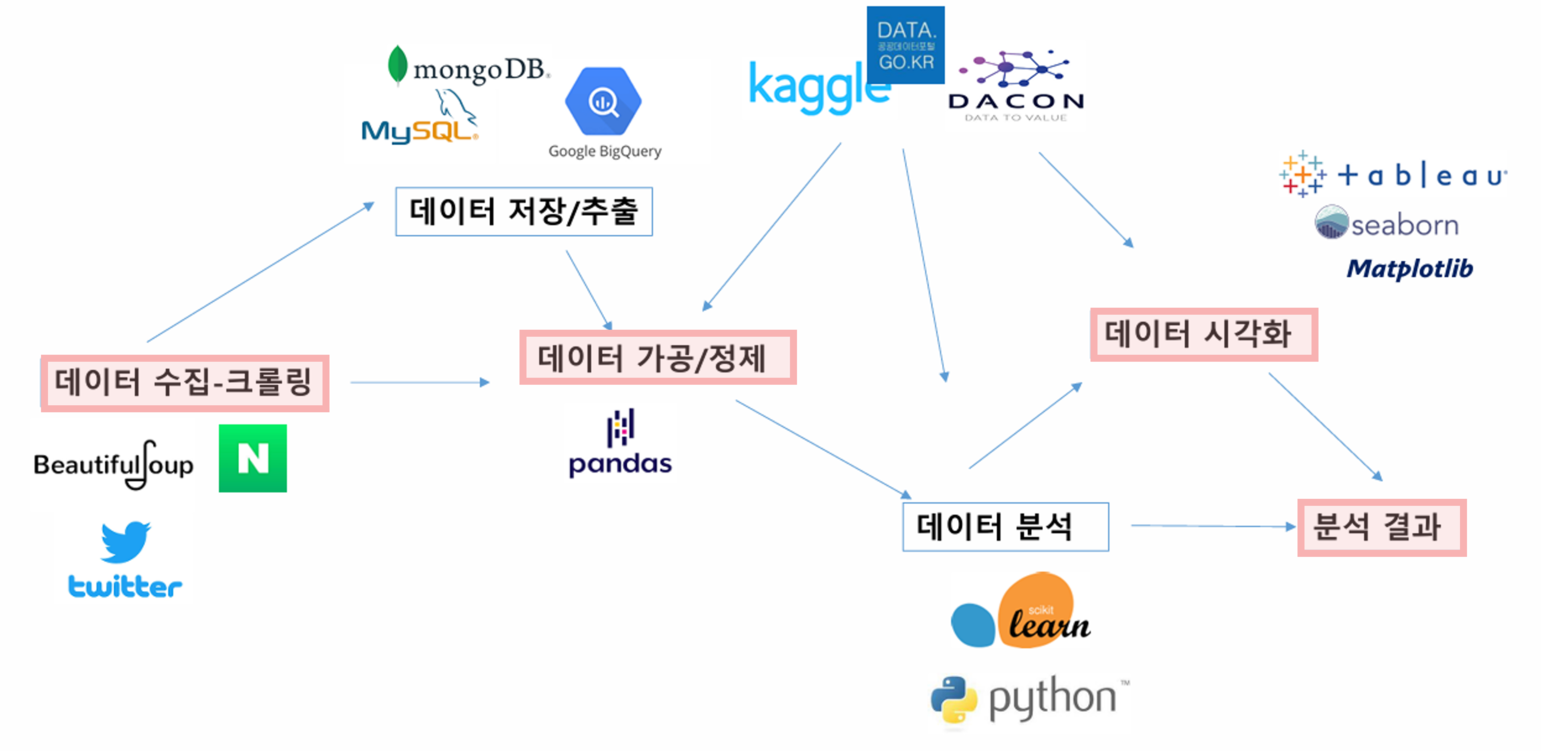

## 데이터 수집 (news_crawling.py)
원하는 정보 년도: 2003~2024

네이버 뉴스 API는 최신 뉴스만 제공

-> beautifulSoup 으로 크롤링

#### 필요 라이브러리 Import


In [ ]:
import requests
from bs4 import BeautifulSoup
import urllib.parse
from datetime import datetime as dt
import csv

#### 크롤링할 지역, 날짜 범위 설정

In [ ]:
regions = ["서울", "경기", "인천"]
start_year = 2003
end_year = 2024

#### 각 지역에 맞춰 키워드 설정 및 결과 저장할 파일 명 설정

In [ ]:
for region in regions:
    query = f"{region} 축제"
    region_file_map = {
        "서울": "seoul",
        "경기": "gyeonggi",
        "인천": "incheon"
    }

#### HTTP 헤더 설정 ( 크롤러 차단 방지 )

In [ ]:
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:96.0) Gecko/20100101 Firefox/96.0',
        'Accept-Language': 'ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7',
        'Accept-Encoding': 'gzip, deflate, br',
        'Connection': 'keep-alive',
        'Upgrade-Insecure-Requests': '1',
        'Cache-Control': 'max-age=0',
        'Host': 'search.naver.com',
        'Referer': 'https://www.naver.com/'
    }

#### 저장할 csv파일을 열고 헤더 작성

In [ ]:
    output_file = f"{region_file_map[region]}_{start_year}_{end_year}_news.csv"
    print(f"뉴스 파일 저장 경로: {output_file}")

    with open(output_file, 'w', newline='', encoding='utf8') as csvfile:
        fieldnames = ['year', 'month', 'title', 'description', 'pubDate']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

#### 날짜 범위에 맞춰 URL 설정 후 뉴스 리스트 수집

In [ ]:
        # 2003 ~ 2024 년
        for year in range(start_year, end_year + 1):
            # 1 ~ 12 월
            for month in range(1, 13):
                cnt = 0
                start_date = f"{year}-{month:02d}-01"
                end_date = f"{year}-{month + 1:02d}-01" if month != 12 else f"{year + 1}-01-01"

                # 날짜 포맷 변경 (YYYY.MM.DD)
                start_date_str = dt.strptime(start_date, "%Y-%m-%d").strftime("%Y.%m.%d")
                end_date_str = dt.strptime(end_date, "%Y-%m-%d").strftime("%Y.%m.%d")

                # 날짜 범위에 맞는 URL 설정
                nso = f"so:r,p:from{start_date.replace('-', '')}to{end_date.replace('-', '')}"
                url = f"https://search.naver.com/search.naver?where=news&query={urllib.parse.quote(query)}&start=1&sm=tab_opt&sort=2&photo=0&field=0&pd=3&ds={start_date_str}&de={end_date_str}&docid=&related=0&mynews=0&office_type=0&office_section_code=0&news_office_checked=&nso={nso}&is_sug_officeid=0&office_category=0&service_area=0"

                print(f"Requesting news for {region} - {year}-{month:02d}, Page 1... URL: {url}")
                response = requests.get(url, headers=headers)

                if response.status_code != 200:
                    print(f"Failed to fetch data from Naver: {response.status_code}")
                    break

                soup = BeautifulSoup(response.text, 'html.parser')
                news_items = soup.find_all('li', class_='bx')
                print(f"Found {len(news_items)} news items")

                if not news_items:
                    break

#### 각 뉴스 별로 제목, 설명, 발행일 수집

In [ ]:
                for post in news_items:
                    title_tag = post.find('a', class_='news_tit')
                    if not title_tag:
                        continue
                    title = title_tag.text.strip()

                    description_tag = post.find('div', class_='news_dsc')
                    description = description_tag.text.strip() if description_tag else ''

                    date_span = post.find('span', class_='info')
                    pub_date = date_span.text.strip() if date_span else None

                    if not pub_date:
                        continue

                    try:
                        # 날짜 포맷 변경 (YYYY.MM.DD)
                        pub_date_obj = dt.strptime(pub_date, "%Y.%m.%d.")
                    except ValueError:
                        # 날짜 포맷이 맞지 않으면 오늘 날짜 사용
                        pub_date_obj = dt.today()

### 수집된 결과 CSV 파일에 저장

In [ ]:
                    writer.writerow({
                        'year': year,
                        'month': month,
                        'title': title,
                        'description': description,
                        'pubDate': pub_date_obj.strftime("%Y-%m-%d %H:%M:%S")
                    })

### 예시 출력

In [ ]:
seoul_news=pd.read_csv('/content/seoul_2003_2024_news.csv')
seoul_news.head()

,year,month,title,description,pubDate
0,2003,1,"이민100주년 꽃차, 로즈 퍼레이드에서 인기",이민 100주년 남가주기념사업회 로즈퍼레이드 한인축제위원회(총회장 토머스 정)가 출...,2003-01-02 00:00:00
1,2003,1,"촛불시위 제안 네티즌 '앙마'오마이뉴스 선정, '올해의 인물'",'예정시간' 오후 6시를 20여분 앞둔 서울 광화문 교보빌딩 앞엔 이미 40여명의 ...,2003-01-02 00:00:00
2,2003,1,"‘Hi, Seoul’브랜드 개발","리외교를 통해 도시의 산업을 마케팅하고 도시의 이미지, 브랜드 , 역사를 문화자본으...",2003-01-02 00:00:00
3,2003,1,[無言의 무대…無限의 감동] 캐나다 눈 극단 ‘별지기’外,7일부터 2월2일까지 서울 세종문화회관 컨벤션홀에서 첫 내한공연을 갖는 캐나다의 눈...,2003-01-02 00:00:00
4,2003,1,“우리가락에 주파수 맞춰보세요”…이윤경 국악방송 프로듀서,국립국악고를 나와 서울대 음대에서 해금연주자로 명성을 날리다 서울대 대학원에서 국악...,2003-01-02 00:00:00


## 데이터 추출 및 정제 (festival_analyze.py)


### 축제 데이터 추출

#### 필요 라이브러리 설치


In [ ]:
!pip install konlpy

#### 필요 라이브라리 Import

In [ ]:
import pandas as pd
import re
from concurrent.futures import ThreadPoolExecutor
from konlpy.tag import Okt

#### 지역 설정

In [ ]:
regions = ['seoul', 'incheon', 'gyeonggi']

#### 저장될 딕셔너리, 축제 명 추출할 패턴 선언

In [ ]:
# 지역별로 축제 목록 저장
festival_dict = {}
# 축제 명칭 패턴 정의
pattern = re.compile(r'(?<!\S)([가-힣\s]+)(축제|박람회|콘테스트)(?!\S)')

#### 각 지역 별 축제 명 처리하는 함수

해당 지역 CSV 파일 순차적으로 읽기

In [ ]:
def process_region(region):
    filename = f"{region}_2003_2024_news.csv"
    region_festivals = []

    try:
        # pandas로 CSV 파일 읽기
        cases = pd.read_csv(filename, encoding='utf8')
        for _, row in cases.iterrows():

제목 또는 설명에서 축제 명 추출

In [ ]:
            try:
                year = row['year']
                month = row['month']
                title = row.get('title', '')
                description = row.get('description', '')

                # 축제 찾기
                match = pattern.search(title)
                if not match:
                    match = pattern.search(description)

                if match:
                    festival_name = match.group(0).strip()
                    region_festivals.append((year, month, festival_name))
                    print(f"추출된 축제 이름: {festival_name}")
                else:
                    print("축제 이름을 찾을 수 없습니다.")
            except KeyError:
                print("필요한 키가 없습니다. 무시하고 진행합니다.")
    except FileNotFoundError:
        print(f"{filename} 파일이 없습니다.")
        return region, region_festivals

    print(f"{region} 지역 축제 이름 {len(region_festivals)}개 추출 완료")
    return region, region_festivals

#### 병렬로 각 지역 축제 명 추출

In [ ]:
    with ThreadPoolExecutor() as executor:
        results = executor.map(process_region, regions)

#### 추출된 축제 정보 딕셔너리에 저장

In [ ]:
    for region, festivals in results:
        if festivals:
            festival_dict[region] = festivals

### 축제 데이터 정제

#### 축제 명 정제 함수


특정 단어 이후 삭제

In [ ]:
def refine_festival_name(festival_name):
    # '및' 이후 삭제
    if '및' in festival_name:
        festival_name = festival_name.split('및', 1)[0].strip()

형태소 분석 및 명사 추출

In [ ]:
    # 형태소 분석 및 명사 추출
    okt = Okt()
    pos_tags = okt.pos(festival_name)
    filtered_name = []
    found_noun = False

    for word, pos in reversed(pos_tags):
        # 명사일 경우 추가
        if pos == 'Noun':
            filtered_name.insert(0, word)
            found_noun = True
        elif found_noun:
            break

정제된 축제 명 반환

In [ ]:
    # 정제된 축제 이름만 반환 (축제는 제외)
    final_name = " ".join(filtered_name)

    return final_name

#### 정제된 DataFrame 딕셔너리에 저장

In [ ]:
refined_dict = {}  # 정제된 축제 이름을 저장할 딕셔너리

for region, festivals in festival_dict.items():
    # pandas DataFrame으로 변환
    df = pd.DataFrame(festivals, columns=['year', 'month', 'festival_name'])

    # 정제된 축제 명 컬럼 생성 및 축제 명 정제
    df['refined_festival_name'] = df['festival_name'].apply(refine_festival_name)

    # 정제된 DataFrame을 딕셔너리에 저장
    refined_dict[region] = df[['year', 'month', 'festival_name', 'refined_festival_name']]


#### DataFrame을 CSV로 저장

In [ ]:
for region, df_refined in refined_dict.items():
    refined_filename = f"{region}_festivals.csv"
    df_refined.to_csv(refined_filename, index=False, encoding='utf-8')
    print(f"정제된 축제 이름이 '{refined_filename}'에 저장되었습니다.")

### 예시

In [6]:
seoul_festivals=pd.read_csv('/content/seoul_festivals.csv')
seoul_festivals.head()

,year,month,festival_name,refined_festival_name
0,2003,2,과천한마당축제,마당 축제
1,2003,2,나비따라 자운영 축제,자운영 축제
2,2003,2,임수택 과천한마당축제,마당 축제
3,2003,2,과학의 달 거리축제,달 거리 축제
4,2003,3,딸기축제,딸기 축제


## 시각화 (festival_visualization.py)

### 필요 라이브러리 설치

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

### 필요 라이브러리 설치 및 폰트 설정

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

### CSV에서 필요한 정보만 읽어들인 후 딕셔너리에 저장

In [2]:
start_year = 2003
end_year = 2024

seoul = pd.read_csv('seoul_festivals.csv')[['year', 'month', 'refined_festival_name']]
incheon = pd.read_csv('incheon_festivals.csv')[['year', 'month', 'refined_festival_name']]
gyeonggi = pd.read_csv('gyeonggi_festivals.csv')[['year', 'month', 'refined_festival_name']]
df_dict = {'서울': seoul, '인천': incheon, '경기': gyeonggi}

for region, df in df_dict.items():
    print(f"================={region}=================")
    print(df.head())

=================서울=================
   year  month refined_festival_name
0  2003      2                 마당 축제
1  2003      2                자운영 축제
2  2003      2                 마당 축제
3  2003      2               달 거리 축제
4  2003      3                 딸기 축제
=================인천=================
   year  month refined_festival_name
0  2003      1                 빙어 축제
1  2003      2                    축제
2  2003      2                    축제
3  2003      2                악기 박람회
4  2003      3              위해 각각 축제
=================경기=================
   year  month refined_festival_name
0  2003      2            쫄깃쫄깃 황태 축제
1  2003      2                  더 축제
2  2003      3       남양주 세계 야외 공연 축제
3  2003      4                  이 축제
4  2003      4                    축제


### refined_festival_name의 축제 명이 '축제'만으로 이루어져 있을 시 삭제

In [34]:
for region, df in df_dict.items():
    df_dict[region] = df[df['refined_festival_name'] != '축제'].reset_index(drop=True)

    print(f"================={region}=================")
    print(df_dict[region].head())

=================서울=================
   year  month refined_festival_name
0  2003      2                 마당 축제
1  2003      2                자운영 축제
2  2003      2                 마당 축제
3  2003      2               달 거리 축제
4  2003      3                 딸기 축제
=================인천=================
   year  month refined_festival_name
0  2003      1                 빙어 축제
1  2003      2                악기 박람회
2  2003      3              위해 각각 축제
3  2003      3               매화 꽃 축제
4  2003      3                봄맞이 축제
=================경기=================
   year  month refined_festival_name
0  2003      2            쫄깃쫄깃 황태 축제
1  2003      2                  더 축제
2  2003      3       남양주 세계 야외 공연 축제
3  2003      4                  이 축제
4  2003      5                 봄꽃 축제


### 연도 별 지역 축제 개수 비교

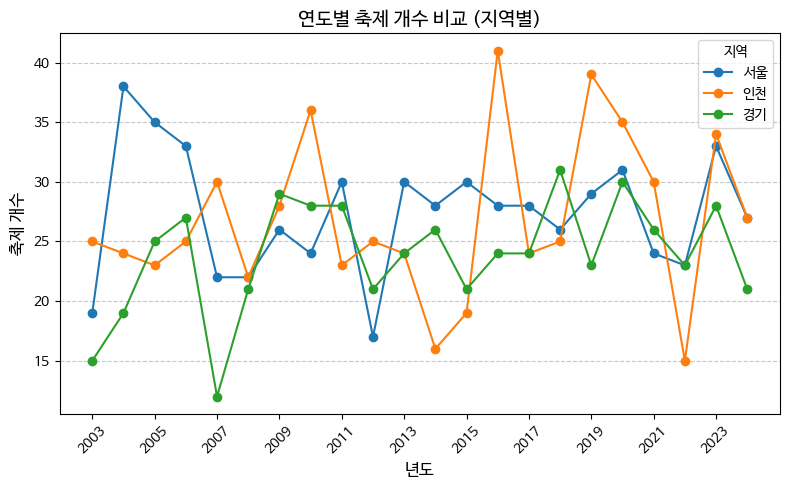

In [9]:
# 각 지역에 대해 데이터 시각화
plt.figure(figsize=(8, 5))

# 각 지역에 대한 선 그래프 추가
for region, df in df_dict.items():
    yearly_counts = df['year'].value_counts().sort_index()

    # 시작 연도와 끝 연도 정의
    start_year = yearly_counts.index.min()
    end_year = yearly_counts.index.max()

    # 선 그래프 그리기
    plt.plot(yearly_counts.index, yearly_counts.values, marker='o', label=region)

# 제목, 라벨 설정
plt.title("연도별 축제 개수 비교 (지역별)", fontsize=14)
plt.xlabel("년도", fontsize=12)
plt.ylabel("축제 개수", fontsize=12)

# x축, y축 설정
plt.xticks(range(start_year, end_year + 1, 2), rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 범례 추가
plt.legend(title="지역", fontsize=10)

# 그래프 표시
plt.tight_layout()
plt.show()

### 월 별 지역 축제 개수 비교

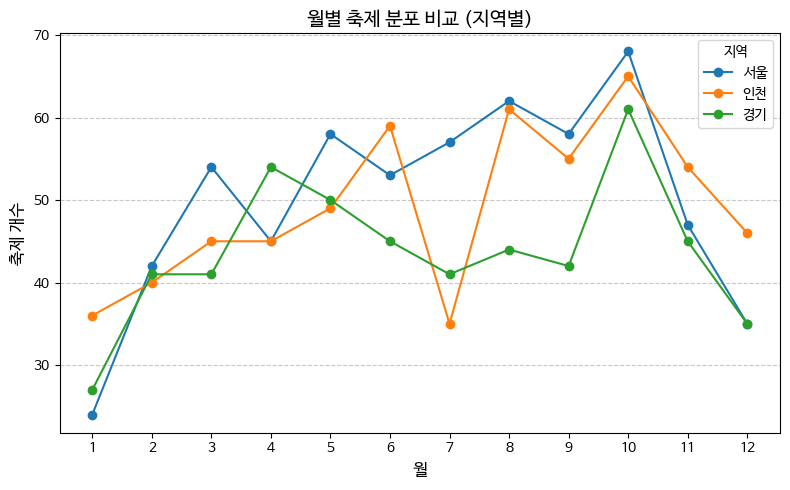

In [8]:
# 월별 축제 분포 시각화
plt.figure(figsize=(8, 5))

# 각 지역에 대한 선 그래프 추가
for region, df in df_dict.items():
    monthly_counts = df['month'].value_counts().sort_index()

    # 월별 축제 개수를 리스트로 저장
    monthly_counts_list = [monthly_counts.get(month, 0) for month in range(1, 13)]

    # 선 그래프 그리기
    plt.plot(range(1, 13), monthly_counts_list, marker='o', label=region)

# 제목, 라벨 설정
plt.title("월별 축제 분포 비교 (지역별)", fontsize=14)
plt.xlabel("월", fontsize=12)
plt.ylabel("축제 개수", fontsize=12)

# x축, y축 설정
plt.xticks(range(1, 13))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 범례 추가
plt.legend(title="지역", fontsize=10)

# 그래프 표시
plt.tight_layout()
plt.show()

### 연도 및 월 별 축제 분포 히트맵

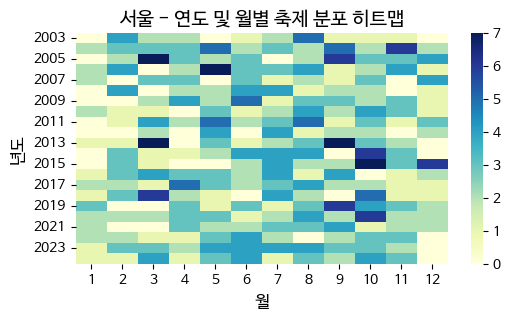

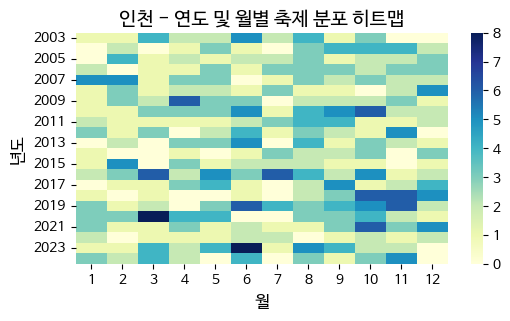

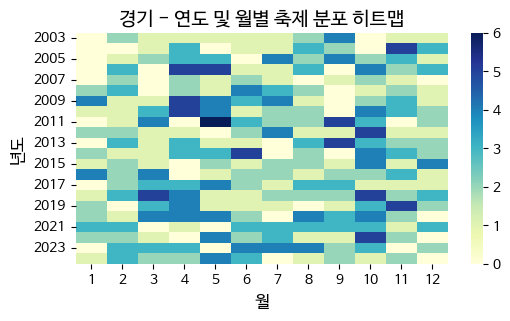

In [27]:
for region, df in df_dict.items():
    # 연도와 월을 기준으로 빈도수 계산
    heatmap_data = pd.crosstab(df['year'], df['month'])

    # 그래프 크기 설정
    plt.figure(figsize=(6, 3))

    # 히트맵 생성
    sns.heatmap(heatmap_data, cmap="YlGnBu", annot=False, cbar=True)

    # 히트맵 제목 설정
    plt.title(f"{region} - 연도 및 월별 축제 분포 히트맵", fontsize=14)

    # x축, y축 설정
    plt.xlabel("월", fontsize=12)
    plt.ylabel("년도", fontsize=12)

    # 그래프 출력
    plt.show()

### 지역 별 워드클라우드

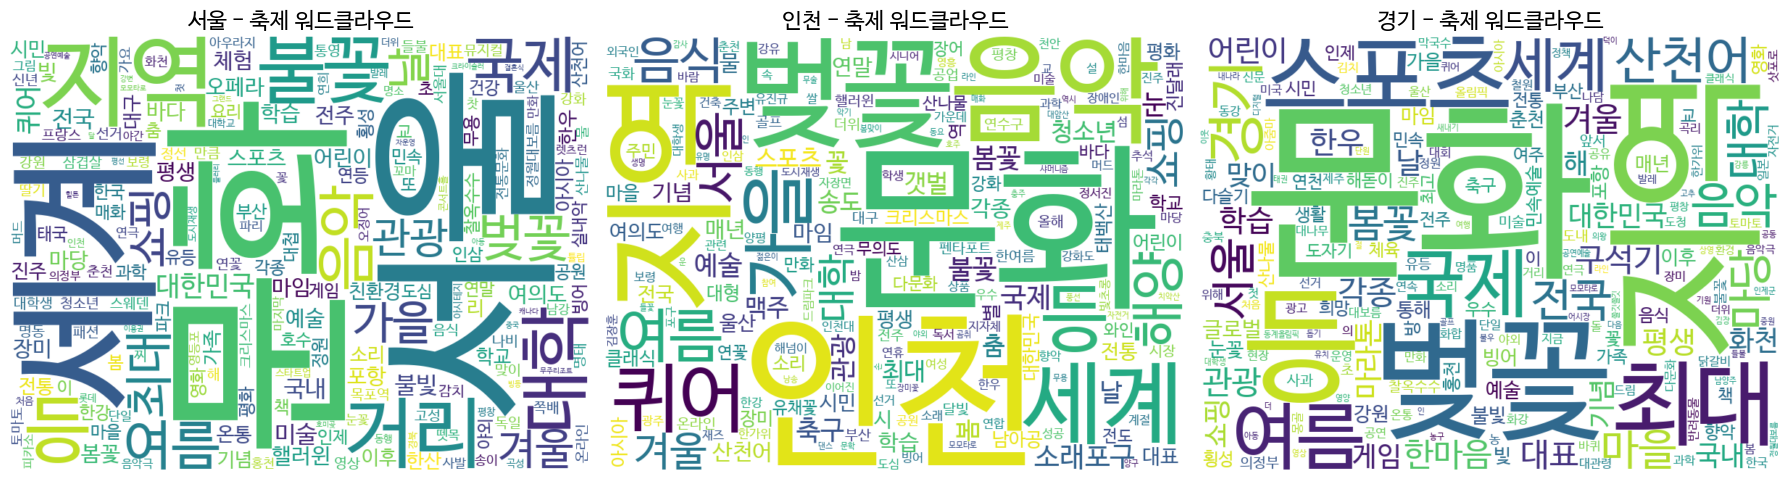

In [40]:
# 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

# 워드클라우드 생성
# 전체 그래프의 크기 설정
plt.figure(figsize=(18, 6))

for idx, (region, df) in enumerate(df_dict.items()):
    # 특정 단어를 제외한 텍스트 생성
    words = ' '.join(df['refined_festival_name'].dropna())
    words = words.replace('축제', '').replace('박람회', '').replace('콘테스트', '')

    # 축제 이름의 빈도수 계산
    word_freq = Counter(words.split())

    # 서브플롯 생성 (가로로 나열)
    plt.subplot(1, len(df_dict), idx + 1)
    wordcloud = WordCloud(font_path=font_path, background_color="white", width=800, height=600).generate_from_frequencies(word_freq)

    # 워드클라우드 시각화
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"{region} - 축제 워드클라우드", fontsize=16)

# 워드클라우드 출력
plt.tight_layout()
plt.show()

### 지역별 단어 빈도 수(Top 15)

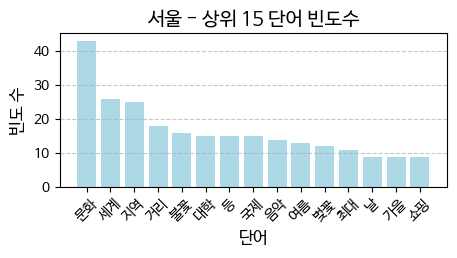

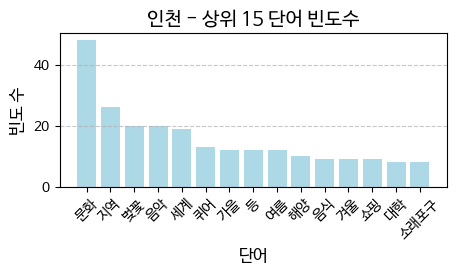

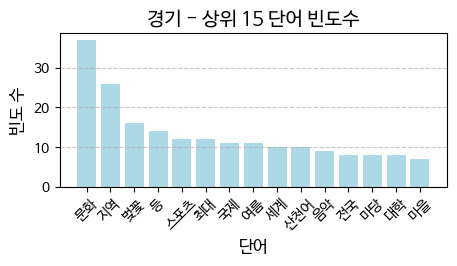

In [42]:
# 텍스트 데이터 전처리 함수
def preprocess_text(dataframe):
    # 특정 단어 제거
    text_data = ' '.join(dataframe['refined_festival_name'].dropna())
    text_data = text_data.replace('축제', '').replace('박람회', '').replace('콘테스트', '').replace('서울', '').replace('인천', '').replace('경기', '')
    tokens = text_data.split()
    return tokens

# 가장 많이 나온 상위 15개 단어를 추출
top_n = 15

for region, df in df_dict.items():
    # 데이터 전처리하여 단어 목록을 얻음
    tokens = preprocess_text(df)

    # 단어 빈도수 계산 (가장 많이 나온 순서대로)
    word_counts = Counter(tokens).most_common(top_n)

    # 단어와 그에 대한 빈도수
    words, counts = zip(*word_counts)

    # 그래프 크기 설정
    plt.figure(figsize=(5, 2))

    # 차트 생성
    plt.bar(words, counts, color='lightblue')

    # 제목, 라벨 설정
    plt.title(f"{region} - 상위 {top_n} 단어 빈도수", fontsize=14)
    plt.xlabel("단어", fontsize=12)
    plt.ylabel("빈도 수", fontsize=12)

    # x축, y축 설정
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # 그래프 출력
    plt.show()

## 결론

- 축제 수의 지역별 비교

    서울이 수도로서 가장 많은 축제가 있을 것으로 예상되었으나, 실제로는 인천과 경기와의 차이가 크지 않다.

- 축제의 월별 분포:

    10월은 전반적으로 축제가 가장 많이 진행되는 달로, 다른 달에 비해 축제 수가 높게 나타난다.

- 축제의 주제:

    문화 관련 축제가 가장 많이 개최되고 있으며, 다양한 문화적 활동이나 행사가 지역 축제에서 중요한 비중을 차지하고 있다. 이는 각 지역에서 문화적 특성을 반영한 축제들이 활발하게 열리고 있음을 나타낸다.